In [1]:
import numpy as np
from pathlib import Path

DATA_DIR = Path.cwd().parent / 'data'

sessions = np.array([])
for file in sorted(DATA_DIR.glob("steinmetz_part*.npz")):
    print(f"Loading {file}...")
    session = np.load(DATA_DIR / file, allow_pickle=True)
    sessions = np.hstack((sessions, session['dat']))

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [2]:
with open(DATA_DIR / "selectors.npy", "rb") as f:
    selectors = np.load(f, allow_pickle=True)

In [3]:
for i in range(len(sessions)):
    session = sessions[i]
    sel = selectors[i]
    neuron_count = sum(sel["NEURON_ACTION"])
    if neuron_count == 0 or not sum(sel["NEURON_VISUAL"]):
        continue
    ratio = len(session['response']) / neuron_count
    print(f"Session {i:2d} - {neuron_count:3d} neurons - {len(session['response']):3d} trials - {ratio:2.2f} ratio")

Session  0 - 113 neurons - 214 trials - 1.89 ratio
Session  3 -  92 neurons - 249 trials - 2.71 ratio
Session  6 -  39 neurons - 252 trials - 6.46 ratio
Session  7 - 112 neurons - 250 trials - 2.23 ratio
Session 10 - 447 neurons - 342 trials - 0.77 ratio
Session 11 -   6 neurons - 340 trials - 56.67 ratio
Session 12 -  61 neurons - 300 trials - 4.92 ratio
Session 13 - 200 neurons - 268 trials - 1.34 ratio
Session 17 - 304 neurons - 316 trials - 1.04 ratio
Session 18 - 185 neurons - 247 trials - 1.34 ratio
Session 20 - 377 neurons - 124 trials - 0.33 ratio
Session 21 -  65 neurons - 444 trials - 6.83 ratio
Session 24 -  80 neurons - 261 trials - 3.26 ratio
Session 25 - 166 neurons - 178 trials - 1.07 ratio
Session 26 -  97 neurons - 253 trials - 2.61 ratio
Session 27 -  62 neurons - 142 trials - 2.29 ratio
Session 28 - 410 neurons - 128 trials - 0.31 ratio
Session 31 - 110 neurons - 260 trials - 2.36 ratio
Session 32 -  59 neurons - 191 trials - 3.24 ratio
Session 34 -  34 neurons - 311

In [4]:
DECODER_SESSION = 10
SESSION = sessions[DECODER_SESSION]
SELECTOR = selectors[DECODER_SESSION]

CHOSEN_TRIALS = np.copy(SELECTOR["CHOICE_NONE"])
CHOSEN_TRIALS[np.where(~CHOSEN_TRIALS)[0][:CHOSEN_TRIALS.sum()]] = True

CLASS_NAMES = ["NoGo", "Go"]
NUM_CLASSES = len(CLASS_NAMES)

In [5]:
from scipy import signal

def get_spikes(session, neurons, trials, bins, align=50, baseline_bins=None, smoothing=None):
    bins = np.atleast_1d(align)[:, np.newaxis] + np.arange(*bins)
    bins += np.minimum(session['spks'].shape[2] - bins[:, -1] - 1, 0)[:, np.newaxis]
    bins -= np.minimum(bins[:, 0], 0)[:, np.newaxis]
    bins = bins[np.newaxis, :, :]

    if smoothing is not None:
        size = smoothing[0] // 2
        bins = np.concatenate(
            [
                bins[:, :, :size] - size,
                bins,
                bins[:, :, -size:] + size
            ],
            axis=2
        )
        bins += np.minimum(session['spks'].shape[2] - bins[:, :, -1] - 1, 0)[:, :, np.newaxis]
        bins -= np.minimum(bins[:, :, 0], 0)[:, :, np.newaxis]

    spikes = np.take_along_axis(session['spks'][neurons][:, trials], bins, 2)
    
    if baseline_bins is not None:
        start, end = baseline_bins
        baseline = session['spks'][neurons][:, trials][:, :, start:end]
        baseline = baseline.mean(axis=2)[:, :, np.newaxis]
        spikes = (spikes - baseline) / (baseline + 0.5)
        
    if smoothing is not None:
        size, std = smoothing
        half_gaussian = signal.gaussian(size, std)
        half_gaussian[size//2 + 1:] = 0
        spikes = signal.convolve(spikes, half_gaussian[np.newaxis, np.newaxis, :], mode='valid')
    
    return spikes

def reshape_by_bins(spikes):
    return spikes.transpose((1, 2, 0)).reshape(spikes.shape[1] * spikes.shape[2], spikes.shape[0])

# Confidence-based Classifier

In [6]:
reaction_times = SESSION['reaction_time'][CHOSEN_TRIALS, 0] / 10 + 50
no_response = np.isinf(reaction_times)
reaction_times[no_response] = reaction_times[~no_response].mean()
reaction_times = reaction_times.astype(int)

spikes = get_spikes(
    SESSION,
    SELECTOR["NEURON_ACTION"],
    CHOSEN_TRIALS,
    (-50, 20),
    align=reaction_times,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
NUM_BINS_TRAIN = 40
NUM_BINS_FULL = spikes.shape[2]
action = 1 - SELECTOR["CHOICE_NONE"][CHOSEN_TRIALS]

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

trials = np.arange(spikes.shape[1])
skf = StratifiedKFold(n_splits=5)
y_pred = np.zeros((len(action) * NUM_BINS_TRAIN))
scores = []
clf = LogisticRegression(penalty='l2', solver='saga', max_iter=5000)
for train_index, val_index in skf.split(trials, action):
    X_train = reshape_by_bins(spikes[:, train_index, -NUM_BINS_TRAIN:])
    X_val = reshape_by_bins(spikes[:, val_index, -NUM_BINS_TRAIN:])
    y_train = np.repeat(action[train_index], NUM_BINS_TRAIN)
    y_val = np.repeat(action[val_index], NUM_BINS_TRAIN)
    
    split_clf = LogisticRegression(**clf.get_params())
    split_clf.fit(X_train, y_train)
    split_pred = split_clf.predict(X_val)
    scores.append(np.mean(split_pred == y_val))
    y_pred[(val_index[:, np.newaxis] * NUM_BINS_TRAIN + np.arange(NUM_BINS_TRAIN)).flatten()] = split_pred

print(scores)
print(np.mean(scores))

[0.7698717948717949, 0.7211538461538461, 0.8685897435897436, 0.925, 0.8638157894736842]
0.8296862348178138


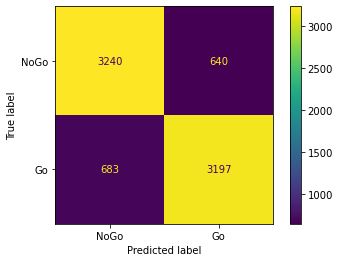

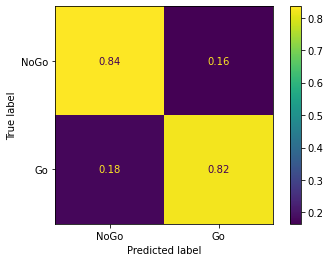

In [8]:
y = np.repeat(action, NUM_BINS_TRAIN)
confusion = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.float32)
confusion[0, 0] = np.sum(~y.astype(bool) & ~y_pred.astype(bool))
confusion[0, 1] = np.sum(~y.astype(bool) & y_pred.astype(bool))
confusion[1, 0] = np.sum(y.astype(bool) & ~y_pred.astype(bool))
confusion[1, 1] = np.sum(y.astype(bool) & y_pred.astype(bool))

ConfusionMatrixDisplay(confusion.astype(np.int32), display_labels=CLASS_NAMES).plot()
ConfusionMatrixDisplay(confusion / confusion.sum(axis=1, keepdims=True), display_labels=CLASS_NAMES).plot()
CONFIDENCE_THRESHOLD = confusion[1,1] / confusion[:, 1].sum()

In [9]:
clf.fit(
    reshape_by_bins(spikes[:, :, -NUM_BINS_TRAIN:]),
    np.repeat(action, NUM_BINS_TRAIN)
)

LogisticRegression(max_iter=5000, solver='saga')

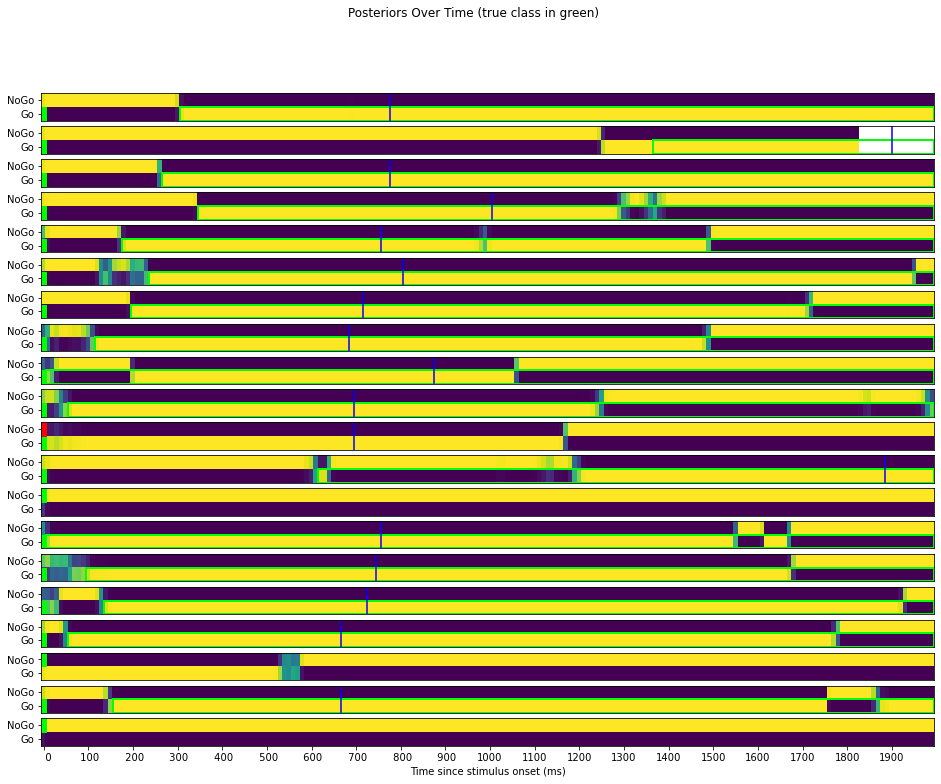

In [10]:
%matplotlib inline
X = reshape_by_bins(get_spikes(
    SESSION,
    SELECTOR["NEURON_ACTION"],
    CHOSEN_TRIALS,
    (0, 200),
    align=50,
    baseline_bins=None,
    smoothing=(17, 2.5),
))
NUM_BINS_FULL = X.shape[0] // sum(CHOSEN_TRIALS)

plotted_trials = 20
xticks = np.arange(NUM_BINS_FULL // 10) * 10
xticklabels = [f"{i*10:4d}" for i in xticks]
fig, axes = plt.subplots(plotted_trials, 1, sharey=True)
fig.set_size_inches(16, 12)
fig.suptitle(f"Posteriors Over Time (true class in green)")

mouse_correct = SELECTOR["CHOICE_CORRECT"][CHOSEN_TRIALS].astype(int)
confusion_matrices = np.zeros((2, NUM_CLASSES, NUM_CLASSES), dtype=int)
decision_times = np.zeros(spikes.shape[1], dtype=int)
decisions = np.zeros_like(decision_times)
eps = np.finfo(float).eps

for trial_num in range(spikes.shape[1]):
    population_activity = X[(trial_num*NUM_BINS_FULL):((trial_num+1)*NUM_BINS_FULL), :]
    likelihoods = clf.predict_log_proba(population_activity)
    
    probs = np.zeros_like(likelihoods)
    probs[0] = likelihoods[0]
    for i in range(1, NUM_BINS_FULL):
        prob = np.exp(probs[i - 1] + likelihoods[i]) + eps
        probs[i] = np.log(prob / prob.sum())
    probs = np.exp(probs)
    
    decision = 0
    decided = np.argmax(probs[:, 1:] > CONFIDENCE_THRESHOLD, axis=0)
    if np.any(decided):
        decision = NUM_CLASSES - np.argmax(decided[::-1] > 0) - 1
        decision_times[trial_num] = decided[decision - 1]
        decisions[trial_num] = decision

    correct_class = action[trial_num]
    confusion_matrices[mouse_correct[trial_num], correct_class, decision] += 1

    if trial_num >= plotted_trials:
        continue
    
    ax = axes[trial_num]
    im = ax.imshow(probs.T, vmin=0, vmax=1, aspect='auto')

    ax.axhspan(
        ymin=correct_class-0.5,
        ymax=correct_class+0.5,
        xmin=0,
        xmax=1/NUM_BINS_FULL,
        color=(0, 1, 0)
    )
    if correct_class:
        ax.axvline(x=reaction_times[trial_num]-0.5, color='b')
    if decision > 0:
        ax.axhspan(
            ymin=decision-0.5,
            ymax=decision+0.5,
            xmin=decision_times[trial_num]/NUM_BINS_FULL,
            xmax=1,
            edgecolor='r' if decision != correct_class else (0, 1, 0),
            facecolor=(0, 0, 0, 0),
            lw=2,
        )
    if decision != correct_class:
        ax.axhspan(
            ymin=decision-0.5,
            ymax=decision+0.5,
            xmin=0,
            xmax=1/NUM_BINS_FULL,
            color='r'
        )
        
    ax.set_yticks(np.arange(NUM_CLASSES))
    ax.set_yticklabels(CLASS_NAMES)
    
    if trial_num != plotted_trials - 1:
        ax.set_xticks([])
        continue

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Time since stimulus onset (ms)")

plt.show()

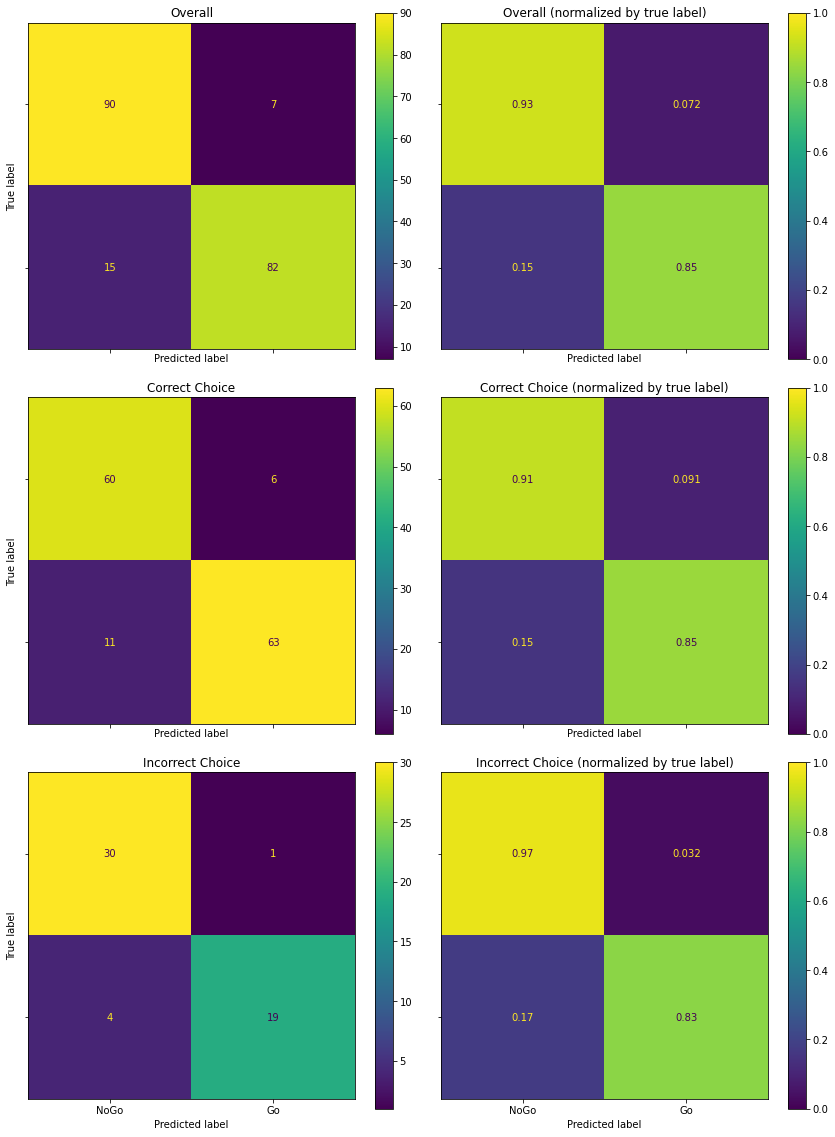

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 16)
fig.set_tight_layout(True)

data = [
    (confusion_matrices.sum(axis=0), "Overall"),
    (confusion_matrices[1], "Correct Choice"),
    (confusion_matrices[0], "Incorrect Choice"),
]
for i, (perf, title) in enumerate(data):
    axes[i, 0].set_title(title)
    ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=axes[i, 0])
    
    ax = axes[i, 1]
    perf = perf / perf.sum(axis=1, keepdims=True)
    disp = ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot(ax=ax)
    disp.im_.colorbar.remove()
    disp.im_ = ax.imshow(perf, vmin=0, vmax=1)
    fig.colorbar(disp.im_, ax=ax)
    ax.set_title(f"{title} (normalized by true label)")
    ax.set_ylabel("")
    ax.set_yticklabels([])

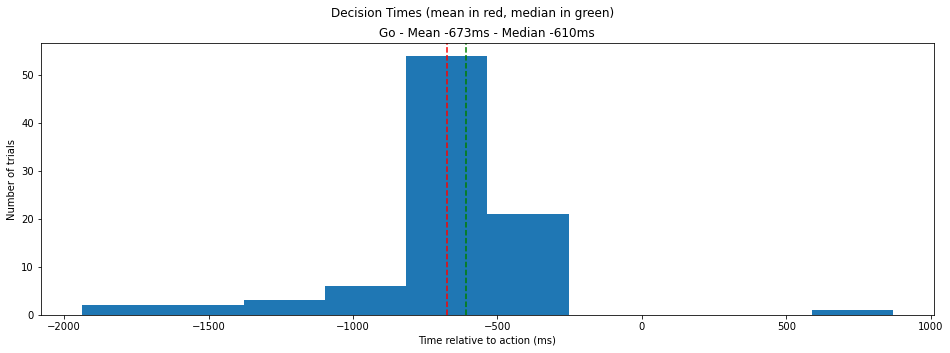

In [12]:
fig = plt.figure()
fig.set_size_inches(16, 5)
fig.suptitle("Decision Times (mean in red, median in green)")

correct_go = (decision_times > 0) & (reaction_times > 0)
correct_decisions = decision_times[correct_go]
correct_reactions = reaction_times[correct_go]

ax = fig.subplots()
class_times = (correct_decisions - correct_reactions) * 10
ax.hist(class_times)
mean_time, median_time = class_times.mean(), np.median(class_times)
ax.axvline(x=mean_time, color='r', linestyle='--')
ax.axvline(x=median_time, color='g', linestyle='--')
ax.set_title(f'{CLASS_NAMES[1]} - Mean {int(mean_time)}ms - Median {int(median_time)}ms')
ax.set_xlabel('Time relative to action (ms)')  
ax.set_ylabel('Number of trials')
fig.show()

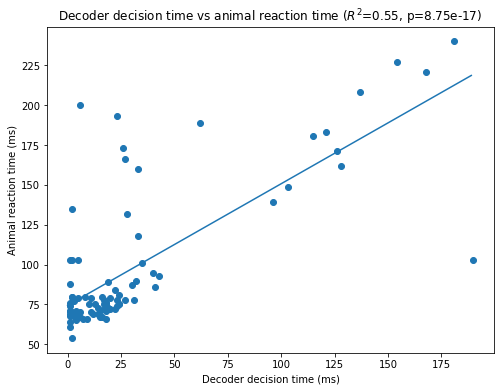

In [13]:
from scipy.stats import linregress

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = fig.subplots()
ax.scatter(correct_decisions, correct_reactions)
ax.set_xlabel('Decoder decision time (ms)');
ax.set_ylabel('Animal reaction time (ms)');

slope, intercept, r, pvalue, stderr = linregress(correct_decisions, correct_reactions)
linreg_x = np.arange(0, correct_decisions.max())
ax.plot(linreg_x, slope * linreg_x + intercept)
_ = ax.set_title(f"Decoder decision time vs animal reaction time ($R^2$={r**2:0.2f}, p={pvalue:0.2e})")

In [14]:
from pathlib import Path
import pickle

results = {}
DECODER_RESULTS = DATA_DIR / 'decoder_results.pickle'
if DECODER_RESULTS.exists():
    with open(DECODER_RESULTS, 'rb') as f:
        results = pickle.load(f)

if DECODER_SESSION not in results:
    results[DECODER_SESSION] = {}

results[DECODER_SESSION]['action'] = {
    'trial_numbers': np.where(CHOSEN_TRIALS)[0],
    'decision_times': decision_times * 10,
    'decisions': np.array(CLASS_NAMES)[decisions],
    'decoder': clf,
}
    
with open(DECODER_RESULTS, 'wb') as f:
    pickle.dump(results, f)

# Histogram-based Classifier

In [15]:
from sklearn.model_selection import cross_val_score

X_hist = get_spikes(
    SESSION,
    SELECTOR["NEURON_ACTION"],
    CHOSEN_TRIALS,
    (-25, 0),
    align=reaction_times,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
X_hist = X_hist.sum(axis=2).T
y_hist = action

hist_clf = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)
scores = cross_val_score(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
print(scores)
print(scores.mean())

[0.79487179 0.79487179 0.84615385 0.92307692 0.92105263]
0.8560053981106612


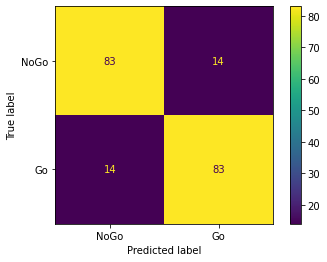

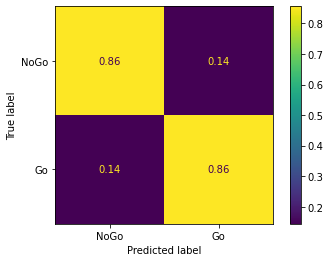

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

y_pred = cross_val_predict(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
perf = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
for i in range(len(y_pred)):
    perf[y_hist[i], y_pred[i]] += 1
    
ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot()
ConfusionMatrixDisplay(perf / perf.sum(axis=1, keepdims=True), display_labels=CLASS_NAMES).plot()

# LDA Classifier

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_lda = get_spikes(
    SESSION,
    SELECTOR["NEURON_ACTION"],
    CHOSEN_TRIALS,
    (-25, 0),
    align=reaction_times,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
lda_bins = X_lda.shape[2]
X_lda = reshape_by_bins(X_lda)
y_lda = np.repeat(action, lda_bins)

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
lda.fit(X_lda, y_lda)
print(lda.explained_variance_ratio_)

[0.02111394]


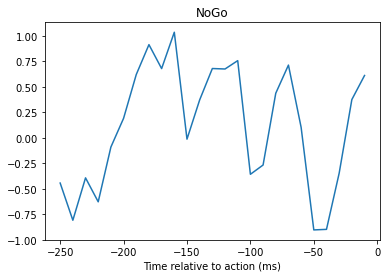

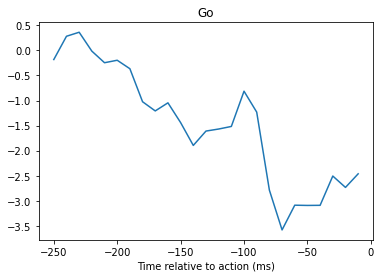

In [18]:
%matplotlib inline

for i, class_name in enumerate(CLASS_NAMES):
    trial_num = np.argmax(action == i)
    transformed = lda.transform(X_lda[trial_num*lda_bins:(trial_num+1)*lda_bins])

    fig = plt.figure()
    ax = fig.subplots()
    ax.plot((np.arange(len(transformed)) - 25)*10, transformed)
    ax.set_title(class_name)
    ax.set_xlabel("Time relative to action (ms)")
    plt.show()